<a href="https://colab.research.google.com/github/arahmanmdmajid/DS_AI_11/blob/main/Time_Series_Analysis_%26_Forecasting_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

!pip install numpy==1.26.4 --quiet

# os.kill(os.getpid(), 9)

In [ ]:
# Instalamos pmdarima
!pip install pmdarima --quiet

In [ ]:
import yfinance as yf
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error

from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

# 1. Time Series Analysis

In [19]:
data = yf.download("NVDA", start="2019-01-01", end="2024-12-31")
data = data[['Close']]
data.dropna(inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,NVDA
Date,
2019-01-02,3.377545
2019-01-03,3.173484
2019-01-04,3.376801
2019-01-07,3.555571
2019-01-08,3.467053


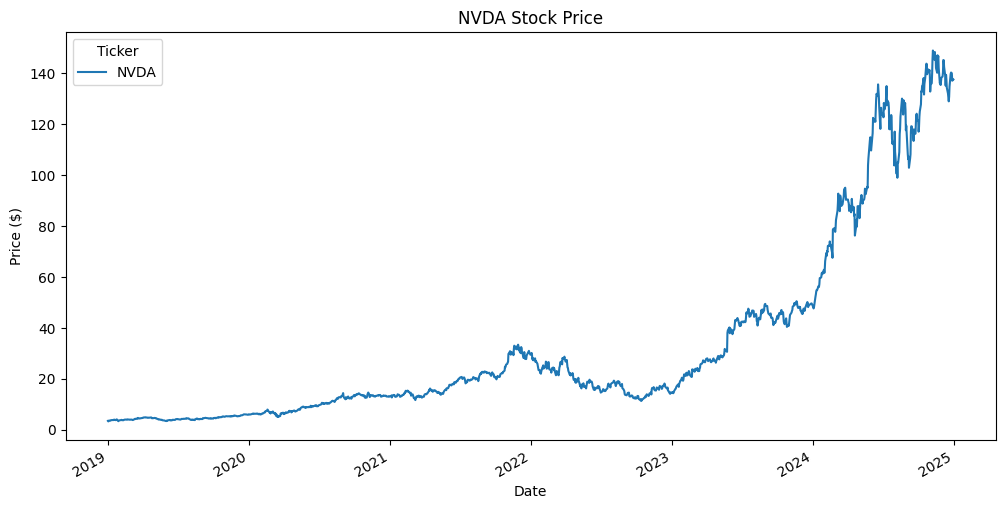

In [20]:
data['Close'].plot(figsize=(12,6), title=f"{ticker} Stock Price")
plt.ylabel('Price ($)')
plt.show()

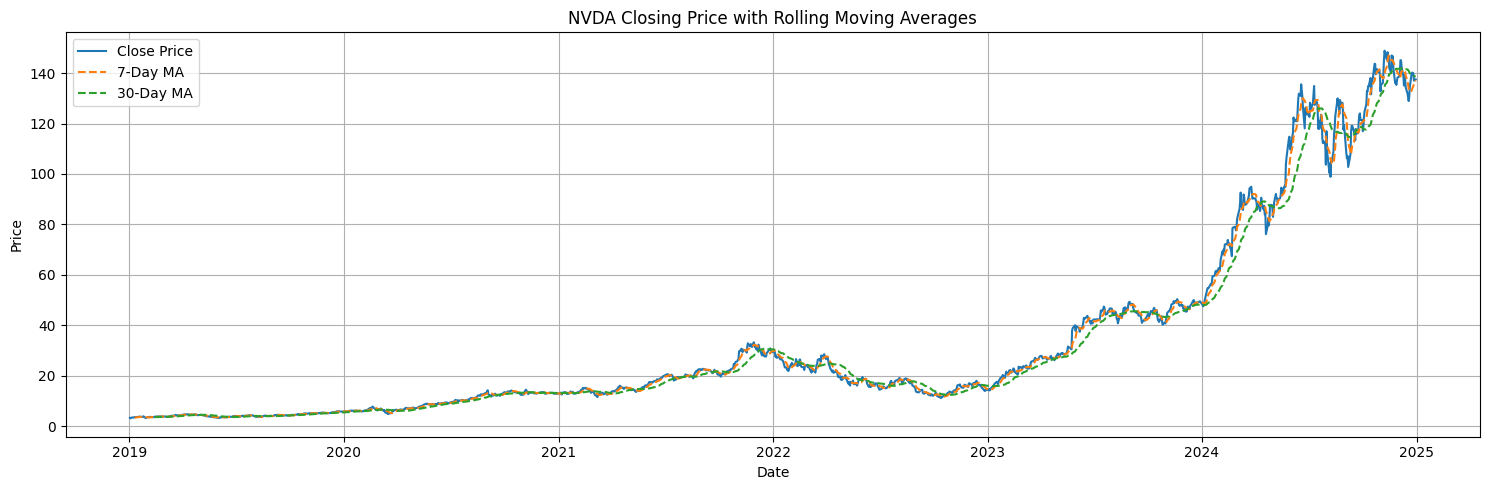

In [21]:
# Rolling averages
data['MA_7Day_Closing'] = data['Close'].rolling(window=7).mean()
data['MA_30Day_Closing'] = data['Close'].rolling(window=30).mean()

plt.figure(figsize=(15,5))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['MA_7Day_Closing'], label='7-Day MA', linestyle='--')
plt.plot(data['MA_30Day_Closing'], label='30-Day MA', linestyle='--')

plt.title('NVDA Closing Price with Rolling Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

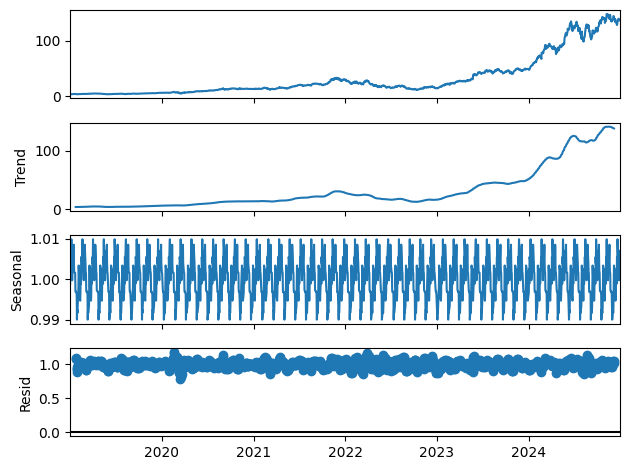

In [23]:
# Seasonal Multiplicative Decomposition
decomp = seasonal_decompose(data['Close'], model='multiplicative', period=30)
decomp.plot()
plt.show()

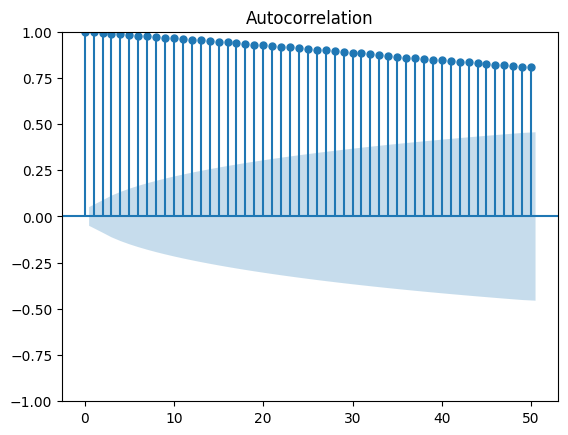

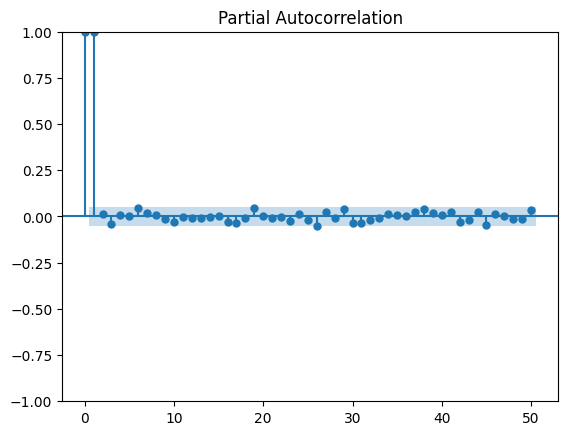

In [29]:
# ACF and PACF plots
plot_acf(data['Close'], lags=50)
plt.show()
plot_pacf(data['Close'], lags=50)
plt.show()

In [31]:
# Stationarity test
def check_stationarity(series):
  result = adfuller(series.dropna())
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])

check_stationarity(data['Close'])

ADF Statistic: 1.730036
p-value: 0.998200


Since p-value is greater than 0.5 then we need to apply differencing

In [32]:
# Differencing
data['Close_diff'] = data['Close'].diff()
check_stationarity(data['Close_diff'])

ADF Statistic: -7.111737
p-value: 0.000000


After 1st Order differencing p-value is now less than 0.5, therefore no further differencing required

# 2. ARIMA Benchmark

In [42]:
# Auto ARIMA to determine optimal (p,d,q) and non-seasonal parameters
model = auto_arima(
    data['Close'],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=None, test='adf',
    seasonal=False,
    trace=True, suppress_warnings=True,
    stepwise=True
)
print("Non-seasonal Auto ARIMA Summary:")
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5589.745, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5601.399, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5596.782, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5597.572, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5604.367, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5590.726, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5590.727, Time=0.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5592.583, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5591.709, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5592.726, Time=3.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5593.204, Time=1.28 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 7.825 seconds
Non-seasonal Auto ARIMA Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No

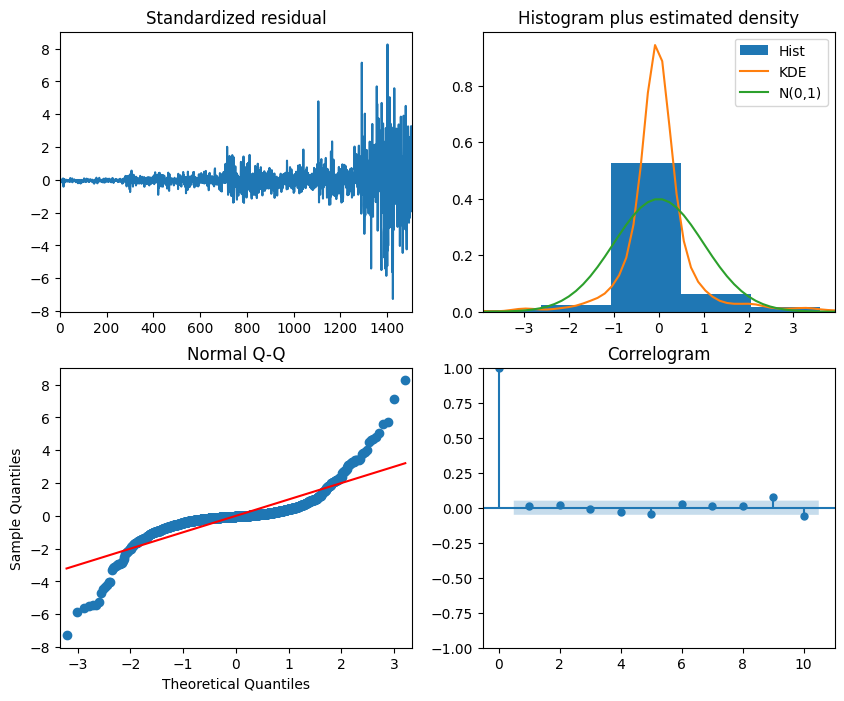

In [44]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

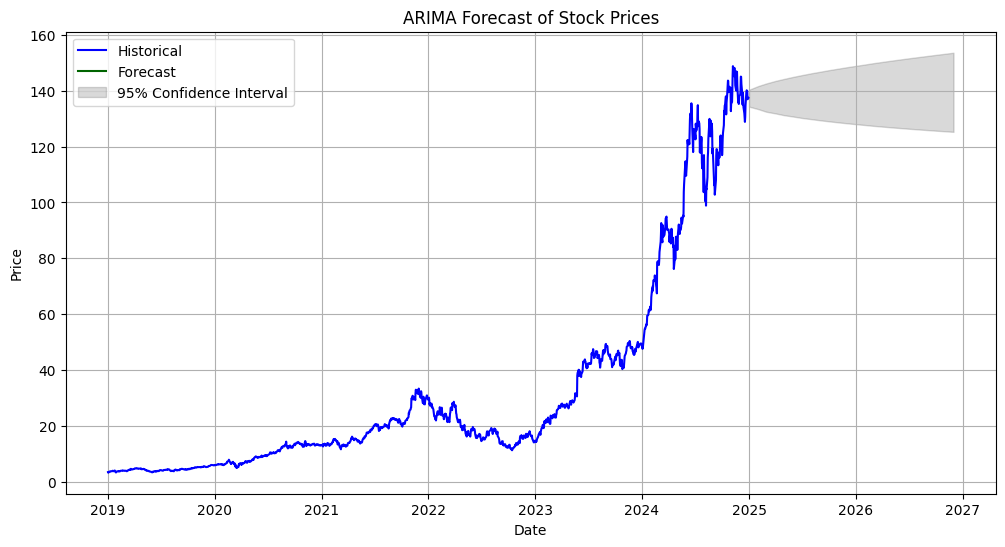

In [51]:
# Forecast
n_periods = 24
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(start=data.index[-1] + pd.offsets.MonthBegin(1), periods=n_periods, freq='MS')

# Create forecast series
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot actual and forecast
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Historical', color='blue')
plt.plot(fitted_series, label='Forecast', color='darkgreen')
plt.fill_between(index_of_fc, lower_series, upper_series, color='k', alpha=0.15, label='95% Confidence Interval')

plt.title("ARIMA Forecast of Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
# Auto ARIMA to determine optimal (p,d,q) and seasonal parameters
stepwise_model = auto_arima(
    data['Close'],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=None, test='adf',
    seasonal=True, m=21,
    trace=True, suppress_warnings=True,
    stepwise=True
)

print("Auto ARIMA Summary:")
print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[21] intercept   : AIC=5585.777, Time=5.57 sec
 ARIMA(0,1,0)(0,0,0)[21] intercept   : AIC=5601.399, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[21] intercept   : AIC=5589.485, Time=1.57 sec
 ARIMA(0,1,1)(0,0,1)[21] intercept   : AIC=5590.632, Time=1.41 sec
 ARIMA(0,1,0)(0,0,0)[21]             : AIC=5604.367, Time=0.06 sec


KeyboardInterrupt: 

[*********************100%***********************]  1 of 1 completed


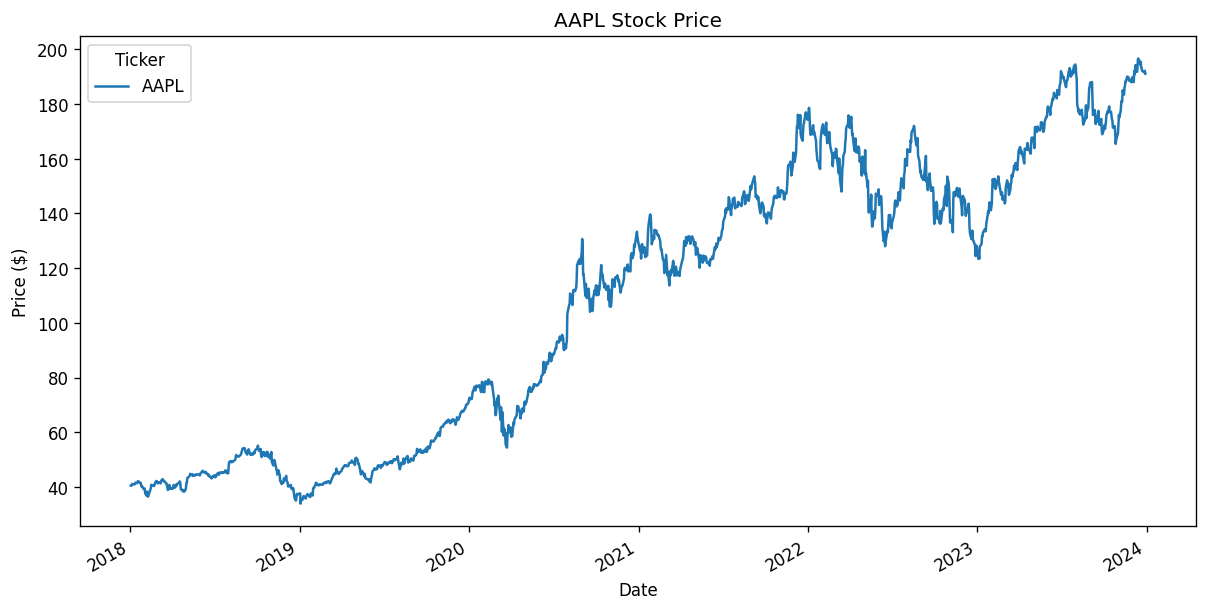

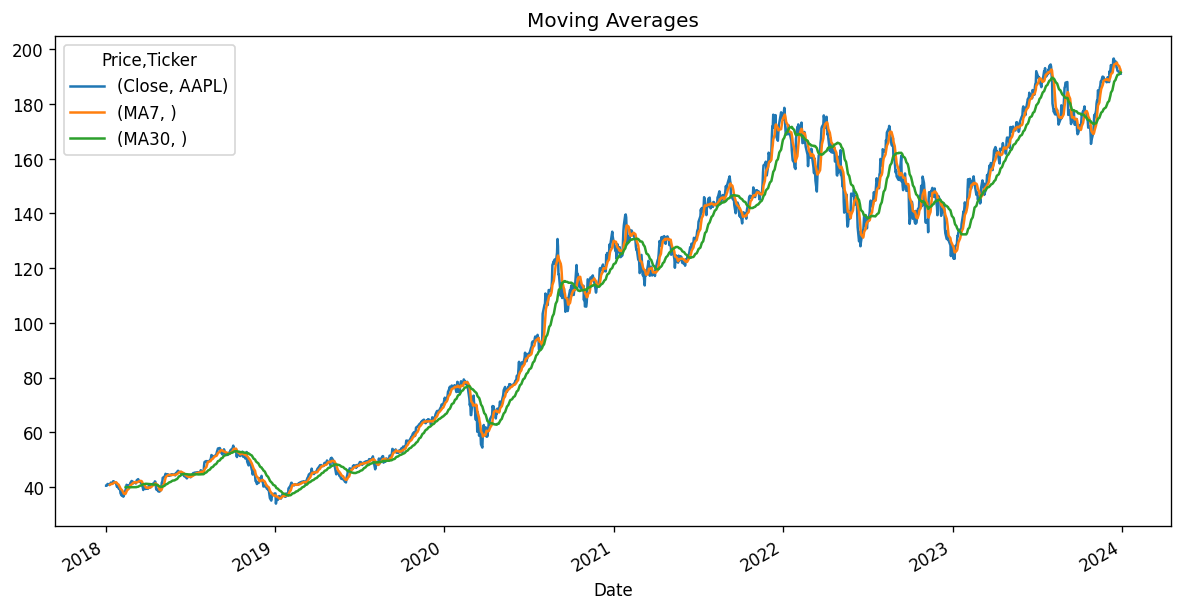

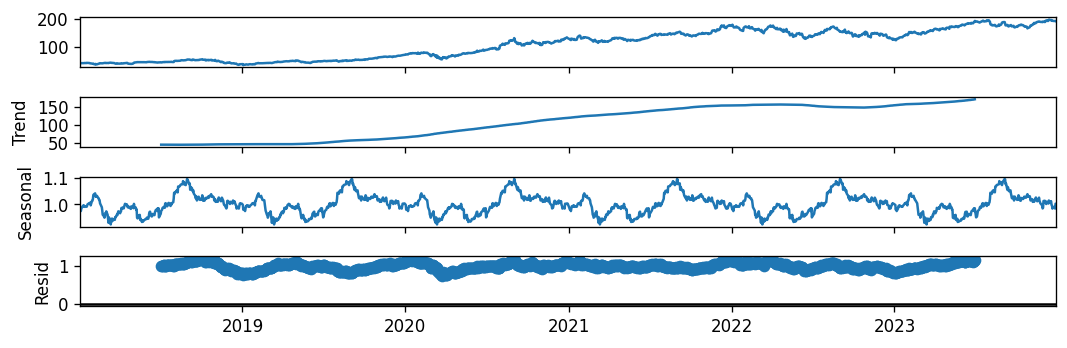

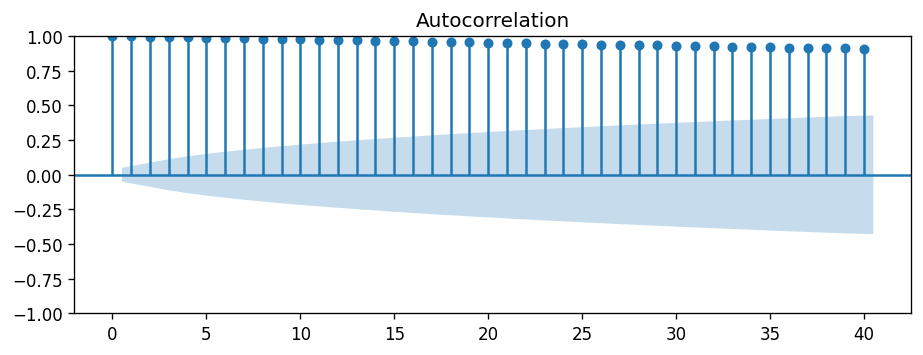

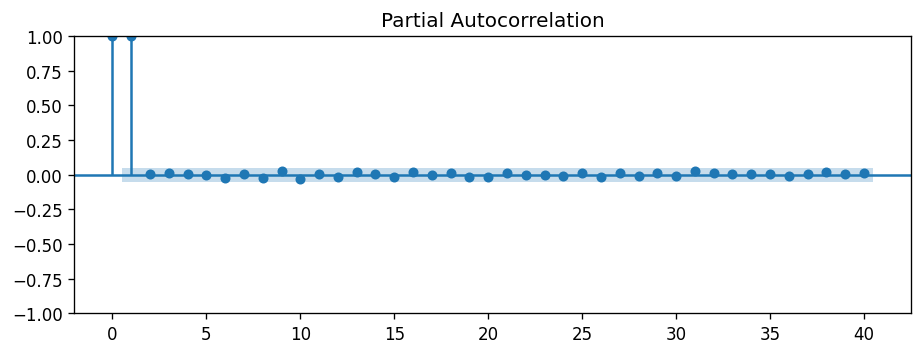

ADF Statistic: -0.5118337863196626
p-value: 0.8896864512429081
ADF Statistic: -40.349904540114004
p-value: 0.0
Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [ ]:


# --- 3. ARIMA MODELING ---


# Fit ARIMA with suggested parameters
model = ARIMA(data['Close'], order=stepwise_model.order,
              seasonal_order=stepwise_model.seasonal_order)
model_fit = model.fit()

# Forecast next 30 days
forecast = model_fit.get_forecast(steps=30)
conf_int = forecast.conf_int()
forecast_index = pd.date_range(start=data.index[-1], periods=30, freq='B')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Observed')
plt.plot(forecast_series, label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# Evaluation (on last 30 known days)
test = data['Close'].iloc[-30:]
pred = model_fit.predict(start=len(data)-30, end=len(data)-1, typ='levels')
mae_arima = mean_absolute_error(test, pred)
rmse_arima = sqrt(mean_squared_error(test, pred))
print('ARIMA MAE:', mae_arima)
print('ARIMA RMSE:', rmse_arima)

# --- 4. LSTM FORECASTING ---

# Prepare supervised data
dataset = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
dataset_scaled = scaler.fit_transform(dataset)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_len = 30
X, y = create_sequences(dataset_scaled, seq_len)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_len, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, verbose=1)

# Predict and inverse scale
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='True')
plt.plot(y_pred_inv, label='Predicted')
plt.title('LSTM Prediction')
plt.legend()
plt.show()

# Evaluation
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_lstm = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('LSTM MAE:', mae_lstm)
print('LSTM RMSE:', rmse_lstm)

# --- 5. COMPARISON AND REFLECTION ---

print("\nComparison Summary:")
print(f"ARIMA MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
print(f"LSTM MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")

print("""
Reflection:
- Auto ARIMA indicated whether seasonality is important.
- Seasonal=True with m=252 (approx. trading days/year) helps in capturing annual cycles.
- LSTM may outperform ARIMA in nonlinear trends but is harder to interpret.
- ARIMA is simpler and interpretable; LSTM is more flexible but complex.
""")
